In [28]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.options.mode.chained_assignment = None

# Read in raw temperature data (df1) and grid (df2) from steps 1 and 2

- Need to run run.py to populate results directory with step[1,2]_output.csv

In [29]:
step1_path = "/Users/aherron1/Documents/Projects/GISTEMP_redo/results/step1_output.csv"
step2_path = "/Users/aherron1/Documents/Projects/GISTEMP_redo/results/step2_output.csv"

df1 = pd.read_csv(step1_path, index_col='Station_ID')
df2 = pd.read_csv(step2_path, index_col='Unnamed: 0')

# Gridding V0: Evaluate if series_next has 20 data points

In [30]:
def gridding_v0(df1, df2):

    # Loop through each point in 2x2 latxlon grid
    point_series_list = []
    for point in tqdm(range(len(df2))):

        # Create dataframe for all stations within range of given point
        nearby_station_str = str(df2.iloc[point]['Nearby_Stations'])
        nearby_station_dict = json.loads(nearby_station_str.replace("'", '"'))
        df_point = df1.loc[df1.index.isin(nearby_station_dict.keys())]
        
        # Loop through all months
        df_month_list = []
        for month in range(1, 13):
            
            # Filter months
            df_month = df_point.filter(regex=f'^{month}_')
            
            # Save original column names for later use
            original_columns = df_month.columns.tolist()
            
            # Add weights column
            df_month['Weight'] = df_month.index.map(lambda station_id: nearby_station_dict.get(station_id))
            
            # Sort stations by number of points
            df_month['Valid Data'] = df_month.filter(regex='_').count(axis=1)
            df_month = df_month.sort_values(by='Valid Data', ascending=False)
            
            # Calculate average per station if not already provided
            station_averages = df_month.filter(regex='_').mean(axis=1)

            # Only get monthly series if there are values
            if len(df_month) > 0:

                # Convert DataFrame to numpy for faster operations
                np_month = df_month.filter(regex='_').to_numpy()
                weights = df_month['Weight'].to_numpy()
                station_averages_np = station_averages.to_numpy()

                # Initialize combined series and weights
                series_combined = np_month[0, :]  # First station's data
                weight_combined = weights[0]

                # Initial mean, avoiding recalculation in each loop
                series_combined_mean = np.nanmean(series_combined) if np.sum(~np.isnan(series_combined)) > 0 else np.nan

                for i in range(1, len(np_month)):
                    series_next = np_month[i]
                    weight_next = weights[i]
                    station_next_avg = station_averages_np[i]

                    ###########################################################
                    ### Only use series_next if it has 20 valid data points ###
                    ###########################################################
                    station_next_valid_data_count = np.count_nonzero(~np.isnan(station_next_avg))
                    if station_next_valid_data_count > 20:

                        # Calculate the new mean for combined series before updating
                        new_combined_mean = (series_combined_mean * weight_combined + station_next_avg * weight_next) / (weight_combined + weight_next)

                        # Adjust series_next using averages (vectorized)
                        series_next_adjusted = series_next + station_next_avg - series_combined_mean

                        # Update series_combined (vectorized)
                        valid_mask = ~np.isnan(series_next_adjusted)
                        series_combined[valid_mask] += series_next_adjusted[valid_mask] * weight_next

                        # Update combined weight
                        weight_combined += weight_next

                        # Update the combined mean
                        series_combined_mean = new_combined_mean

                # Convert the final combined series back to Pandas Series using the original column names
                final_series_combined = pd.Series(series_combined, index=original_columns)
                df_month_list.append(final_series_combined)

        if len(df_month_list) > 0:
            # Combine into series for all months, change index to point number
            complete_point_series = pd.concat(df_month_list, axis=0)
            complete_point_series.name = point

        # Add complete point series to list
        point_series_list.append(complete_point_series)

    # Create dataframe of gridded time series for each point
    df_gridded = pd.concat(point_series_list, axis=1).T

    # Reorder columns to be in time-order
    ordered_columns = []
    for year in range(1880, 2024):
        for month in range(1, 13):
            ordered_columns.append(f'{month}_{year}')
    df_gridded = df_gridded[ordered_columns]

    # Add latitude / longitude coordinates
    df_gridded[['Latitude', 'Longitude']] = df2[['Latitude', 'Longitude']]

    return df_gridded

In [31]:
df_gridded_v0 = gridding_v0(df1, df2)
df_gridded_v0

100%|██████████| 16022/16022 [06:54<00:00, 38.67it/s]


,1_1880,2_1880,3_1880,4_1880,5_1880,6_1880,7_1880,8_1880,9_1880,10_1880,...,5_2023,6_2023,7_2023,8_2023,9_2023,10_2023,11_2023,12_2023,Latitude,Longitude
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.4,-0.85,0.25,0.00,-2.10,-7.1,-15.25,-18.60,88.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.4,-0.85,0.25,0.00,-2.10,-7.1,-15.25,-18.60,88.0,2.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.4,-0.85,0.25,0.00,-2.10,-7.1,-15.25,-18.60,88.0,4.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.4,-0.85,0.25,0.00,-2.10,-7.1,-15.25,-18.60,88.0,6.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.4,-0.85,0.25,0.00,-2.10,-7.1,-15.25,-18.60,88.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-57.9,-57.35,-58.45,-56.65,-56.25,-52.7,-38.44,-28.65,-88.0,354.0
16018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-57.9,-57.35,-58.45,-56.65,-56.25,-52.7,-38.44,-28.65,-88.0,356.0
16019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-57.9,-57.35,-58.45,-56.65,-56.25,-52.7,-38.44,-28.65,-88.0,358.0
16020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.4,-0.85,0.25,0.00,-2.10,-7.1,-15.25,-18.60,90.0,0.0


# Gridding V1: Evaluate if series_next has 20 points of overlap with series_combined

In [32]:
def gridding_v1(df1, df2):

    # Loop through each point in 2x2 latxlon grid
    point_series_list = []
    for point in tqdm(range(len(df2))):

        # Create dataframe for all stations within range of given point
        nearby_station_str = str(df2.iloc[point]['Nearby_Stations'])
        nearby_station_dict = json.loads(nearby_station_str.replace("'", '"'))
        df_point = df1.loc[df1.index.isin(nearby_station_dict.keys())]
        
        # Loop through all months
        df_month_list = []
        for month in range(1, 13):
            
            # Filter months
            df_month = df_point.filter(regex=f'^{month}_')
            
            # Save original column names for later use
            original_columns = df_month.columns.tolist()
            
            # Add weights column
            df_month['Weight'] = df_month.index.map(lambda station_id: nearby_station_dict.get(station_id))
            
            # Sort stations by number of points
            df_month['Valid Data'] = df_month.filter(regex='_').count(axis=1)
            df_month = df_month.sort_values(by='Valid Data', ascending=False)
            
            # Calculate average per station if not already provided
            station_averages = df_month.filter(regex='_').mean(axis=1)

            # Only get monthly series if there are values
            if len(df_month) > 0:

                # Convert DataFrame to numpy for faster operations
                np_month = df_month.filter(regex='_').to_numpy()
                weights = df_month['Weight'].to_numpy()
                station_averages_np = station_averages.to_numpy()

                # Initialize combined series and weights
                series_combined = np_month[0, :]  # First station's data
                weight_combined = weights[0]

                # Initial mean, avoiding recalculation in each loop
                series_combined_mean = np.nanmean(series_combined) if np.sum(~np.isnan(series_combined)) > 0 else np.nan

                for i in range(1, len(np_month)):
                    series_next = np_month[i]
                    weight_next = weights[i]
                    station_next_avg = station_averages_np[i]

                    ################################################################################
                    ### Only use series_next if it has 20 points of overlap with series_combined ###
                    ################################################################################
                    valid_combined = ~np.isnan(series_combined)
                    valid_next = ~np.isnan(series_next)
                    valid_indices = np.logical_and(valid_combined, valid_next)
                    overlapping_count = np.count_nonzero(valid_indices)

                    # Only evaluate if overlapping count exceeds 19
                    if overlapping_count >= 20:

                        # Calculate the new mean for combined series before updating
                        new_combined_mean = (series_combined_mean * weight_combined + station_next_avg * weight_next) / (weight_combined + weight_next)

                        # Adjust series_next using averages (vectorized)
                        series_next_adjusted = series_next + station_next_avg - series_combined_mean

                        # Update series_combined (vectorized)
                        valid_mask = ~np.isnan(series_next_adjusted)
                        series_combined[valid_mask] += series_next_adjusted[valid_mask] * weight_next

                        # Update combined weight
                        weight_combined += weight_next

                        # Update the combined mean
                        series_combined_mean = new_combined_mean

                # Convert the final combined series back to Pandas Series using the original column names
                final_series_combined = pd.Series(series_combined, index=original_columns)
                df_month_list.append(final_series_combined)

        if len(df_month_list) > 0:
            # Combine into series for all months, change index to point number
            complete_point_series = pd.concat(df_month_list, axis=0)
            complete_point_series.name = point

        # Add complete point series to list
        point_series_list.append(complete_point_series)

    # Create dataframe of gridded time series for each point
    df_gridded = pd.concat(point_series_list, axis=1).T

    # Reorder columns to be in time-order
    ordered_columns = []
    for year in range(1880, 2024):
        for month in range(1, 13):
            ordered_columns.append(f'{month}_{year}')
    df_gridded = df_gridded[ordered_columns]

    # Add latitude / longitude coordinates
    df_gridded[['Latitude', 'Longitude']] = df2[['Latitude', 'Longitude']]

    return df_gridded

In [33]:
df_gridded_v1 = gridding_v1(df1, df2)
df_gridded_v1

100%|██████████| 16022/16022 [09:21<00:00, 28.54it/s] 


,1_1880,2_1880,3_1880,4_1880,5_1880,6_1880,7_1880,8_1880,9_1880,10_1880,...,5_2023,6_2023,7_2023,8_2023,9_2023,10_2023,11_2023,12_2023,Latitude,Longitude
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-10.523644,-0.134462,2.542894,1.830932,-3.100388,-10.362785,-20.455508,-26.749775,88.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-10.494081,-0.118095,2.570243,1.838656,-3.076491,-10.319865,-20.393152,-26.631690,88.0,2.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-10.466720,-0.104752,2.593873,1.843704,-3.053838,-10.277611,-20.332781,-26.516976,88.0,4.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-10.441210,-0.094110,2.614049,1.846416,-3.032285,-10.235878,-20.273940,-26.405162,88.0,6.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-10.417300,-0.085923,2.630987,1.847051,-3.011736,-10.194590,-20.216333,-26.295943,88.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-80.837077,-78.866467,-82.514333,-83.434505,-67.378925,-62.997694,-51.039740,-37.227601,-88.0,354.0
16018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-80.914159,-78.945421,-82.592687,-83.465025,-67.403964,-63.017504,-51.089040,-37.272445,-88.0,356.0
16019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-80.990088,-79.022771,-82.670916,-83.495872,-67.429015,-63.039619,-51.136336,-37.315277,-88.0,358.0
16020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-10.314790,-0.657639,1.537429,1.458405,-3.172824,-9.940526,-19.556522,-26.014704,90.0,0.0


# Anomaly Calculation V0: anomaly = raw - baseline_average

In [34]:
def anomaly_v0(df_gridded):

    # Create dataframe for baseline columns
    df_baseline = df_gridded.copy()
    baseline_columns = []
    for year in range(1951, 1981):
        for month in range(1, 13):
            baseline_columns.append(str(month) + '_' + str(year))
    df_baseline = df_baseline[baseline_columns]

    # Calculate anomalies for each month
    df_monthly_anom_list = []
    for month in range(1, 13):

        # Get monthly dataframes and baseline averages
        monthly_columns = [col for col in df_gridded.columns if col.startswith(f'{month}_')]
        df_monthly_anom = df_gridded[monthly_columns]
        df_baseline[f'{month}_Average'] = df_baseline.mean(axis=1)
        df_monthly_anom[f'{month}_Average'] = df_baseline.mean(axis=1)

        # Calculate anomalies for each column
        for col in df_monthly_anom.columns:
            df_monthly_anom[col] = df_monthly_anom[col] - df_monthly_anom[f'{month}_Average']

        # Drop baseline average column, add to list
        df_monthly_anom = df_monthly_anom.drop(columns=[f'{month}_Average'])
        df_monthly_anom_list.append(df_monthly_anom)

    # Create dataframe and sort columns
    df_anom = pd.concat(df_monthly_anom_list, axis=1)
    temp_columns = []
    for year in range(1880, 2024):
        for month in range(1, 13):
            temp_columns.append(str(month) + '_' + str(year))
    df_anom = df_anom[temp_columns]

    # Add Latitude / Longitude coordinates
    lat_lon_columns = df_gridded[['Latitude', 'Longitude']].copy()
    df_anom = pd.concat([df_anom, lat_lon_columns], axis=1)

    return df_anom

In [35]:
df_g0_a0 = anomaly_v0(df_gridded_v0)
df_g1_a0 = anomaly_v0(df_gridded_v1)

# Anomaly Calculation V1:

### if there's 20 valid points in baseline period:

- anomaly = raw - baseline_average

### if not:

- anomaly = raw - timeseries_average

In [36]:
def anomaly_v1(df_gridded):

    # Create dataframe for baseline columns
    df_baseline = df_gridded.copy()
    baseline_columns = []
    for year in range(1951, 1981):
        for month in range(1, 13):
            baseline_columns.append(str(month) + '_' + str(year))
    df_baseline = df_baseline[baseline_columns]

    # Calculate anomalies for each month
    df_monthly_anom_list = []
    for month in range(1, 13):

        monthly_columns = [col for col in df_gridded.columns if col.startswith(f'{month}_')]
        df_monthly_anom = df_gridded[monthly_columns]

        baseline_monthly_columns = [col for col in df_baseline if col.startswith(f'{month}_')]
        df_baseline_monthly = df_baseline[baseline_monthly_columns]

        # Count non-NaN values along the rows
        valid_baseline_data = df_baseline_monthly.notnull().sum(axis=1)

        # Add a new column with the valid counts
        df_baseline_monthly['Valid_Counts'] = valid_baseline_data
        df_baseline_monthly[f'{month}_Average'] = df_baseline_monthly.mean(axis=1)

        # Split into two dataframes (enough valid data / not enough)    
        df_baseline_enough_data = df_baseline_monthly[df_baseline_monthly['Valid_Counts'] >= 20]
        df_baseline_lacking_data = df_baseline_monthly[df_baseline_monthly['Valid_Counts'] < 20]

        indices_enough_data = df_baseline_enough_data.index
        indices_lacking_data = df_baseline_lacking_data.index

        df_monthly_anom_enough = df_monthly_anom.loc[indices_enough_data.drop_duplicates()]
        df_monthly_anom_lacking = df_monthly_anom.loc[indices_lacking_data.drop_duplicates()]

        # Process rows with enough data normally
        for col in df_monthly_anom_enough.columns:
            df_monthly_anom_enough[col] = df_monthly_anom_enough[col] - df_baseline_enough_data[f'{month}_Average']

        # Calculate average for entire timeseries
        df_monthly_anom_lacking['Timeseries Average'] = df_monthly_anom_lacking.mean(axis=1)
        for col in df_monthly_anom_lacking.columns:
            df_monthly_anom_lacking[col] = df_monthly_anom_lacking[col] - df_monthly_anom_lacking['Timeseries Average']
        df_monthly_anom_lacking = df_monthly_anom_lacking.drop(columns=['Timeseries Average'])

        # Combine dataframes with enough and not enough baseline data
        df_all_monthly = pd.concat([df_monthly_anom_enough, df_monthly_anom_lacking]).sort_index()
        df_monthly_anom_list.append(df_all_monthly)

    # Create dataframe and sort columns
    df_anom = pd.concat(df_monthly_anom_list, axis=1)
    temp_columns = []
    for year in range(1880, 2024):
        for month in range(1, 13):
            temp_columns.append(str(month) + '_' + str(year))
    df_anom = df_anom[temp_columns]

    # Add Latitude / Longitude coordinates
    lat_lon_columns = df_gridded[['Latitude', 'Longitude']].copy()
    df_anom = pd.concat([df_anom, lat_lon_columns], axis=1)

    return df_anom

In [37]:
df_g0_a1 = anomaly_v1(df_gridded_v0)
df_g1_a1 = anomaly_v1(df_gridded_v1)

# Plotting A: yearly averages of dataframes

- Note: this does NOT factor in equal area weighting

In [38]:
def plot_yearly_averages(df_anom):
    df_anom_values = df_anom.copy().drop(columns=['Latitude', 'Longitude'])
    global_avg_months = df_anom_values.mean(axis=0)
    global_avg_months.index = pd.to_datetime(global_avg_months.index, format='%m_%Y')
    yearly_averages = global_avg_months.groupby(lambda x: x.year).mean()
    plt.plot(yearly_averages)
    plt.grid()
    plt.xlabel('Year')
    plt.ylabel('Temperature Anomaly (Celsius)')
    plt.title('GISTEMPv5 Global Yearly Average Temperature Anomalies\n(NOT weighted for equal area)')

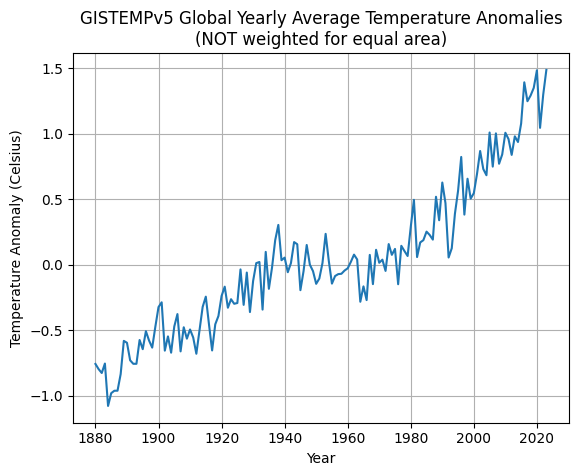

In [39]:
plot_yearly_averages(df_g0_a0)

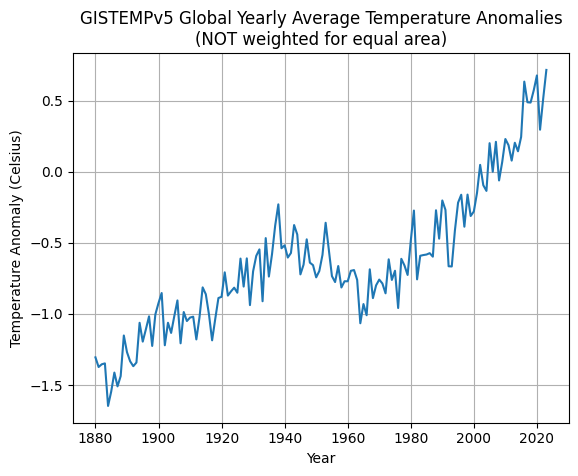

In [40]:
plot_yearly_averages(df_g0_a1)

# Convert Dataframe to Dataset

In [41]:
def dataframe_to_dataset(grid_anomaly: pd.DataFrame):
    """
    Convert a DataFrame with temperature data into an xarray Dataset.

    Parameters:
    - grid_anomaly (DataFrame): Input DataFrame with temperature data, containing columns 'Lat', 'Lon', and columns representing time steps.

    Returns:
    - Dataset: xarray Dataset with temperature data, indexed by latitude, longitude, and time.
    """

    # Create copy of input dataframe, rename columns
    df = grid_anomaly.copy()
    df = df.rename(columns={"Latitude": "lat", "Longitude": "lon"})

    # Reshape dataframe into long format
    df = df.melt(id_vars=["lat", "lon"], var_name="date", value_name="temp")

    # Get months and years, drop duplicate rows
    df[["month", "year"]] = df["date"].str.split("_", expand=True).astype(int)
    df = df.drop_duplicates(subset=["lat", "lon", "month", "year"])

    # Create date column formatted as year-month-01
    dates = df["year"].astype(str) + "-" + df["month"].astype(str) + "-01"

    # Convert dates to datetime objects
    datetimes = pd.to_datetime(dates)

    # Remove unnecessary columns
    df = df.drop(columns=["date", "month", "year"])

    # Create new time column using datetime objects
    df["time"] = pd.to_datetime(datetimes)

    # Set multi-index
    df = df.set_index(["lat", "lon", "time"])

    # Convert pandas dataframe to xarray dataset
    ds = df.to_xarray()
    return ds

In [42]:
ds_g0_a0 = dataframe_to_dataset(df_g0_a0)
ds_g0_a1 = dataframe_to_dataset(df_g0_a1)
ds_g1_a0 = dataframe_to_dataset(df_g1_a0)
ds_g1_a1 = dataframe_to_dataset(df_g1_a1)

# Equal Area Weighting

In [43]:
def area_weight(ds, yearly=False):
    weights = np.cos(np.deg2rad(ds['lat']))
    weights.name = 'weights'
    ds_weighted = ds.temp.weighted(weights)
    ds_weighted_mean = ds_weighted.mean(('lon', 'lat'))
    if yearly:
        return ds_weighted_mean
    else:
        ds_yearly = ds_weighted_mean.resample(time='Y').mean(dim='time')
        return ds_yearly

In [44]:
weighted_timeseries_g0_a0 = area_weight(ds_g0_a0)
weighted_timeseries_g0_a1 = area_weight(ds_g0_a1)
weighted_timeseries_g1_a0 = area_weight(ds_g1_a0)
weighted_timeseries_g1_a1 = area_weight(ds_g1_a1)

# Plotting B: Compare weighted / non-weighted anomalies

In [45]:
def plot_weight_comparison(df_anom, weighted_timeseries):
    df_anom_values = df_anom.copy().drop(columns=['Latitude', 'Longitude'])
    global_avg_months = df_anom_values.mean(axis=0)
    global_avg_months.index = pd.to_datetime(global_avg_months.index, format='%m_%Y')
    yearly_averages = global_avg_months.groupby(lambda x: x.year).mean()

    plt.plot(yearly_averages.values, label='Unweighted')
    plt.plot(weighted_timeseries.values, label='Weighted')
    plt.grid()
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Temperature Anomaly (Celsius)')
    plt.title('GISTEMPv5 Global Yearly Average Temperature Anomalies\n(Weighted for Equal Area vs. Non-Weighted)')

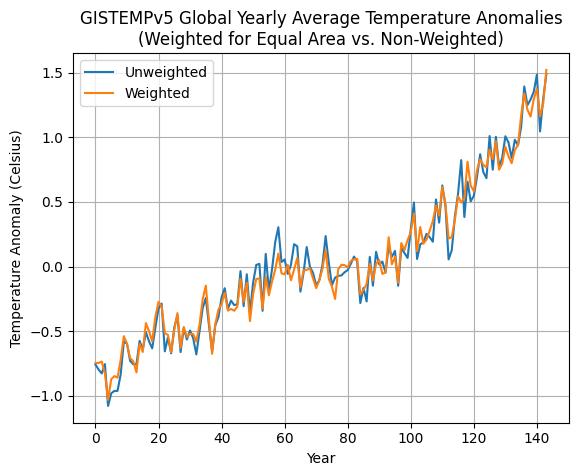

In [46]:
plot_weight_comparison(df_g0_a0, weighted_timeseries_g0_a0)

# MOST IMPORTANT FIGURE

# Plotting C: Comparison of V4 & V5 

In [10]:
# Create v4 anomaly dataframe (steps 0-3)
df_v4 = pd.read_csv('df_v4.csv', index_col='Unnamed: 0')

# Create global average timeseries for v4
df_annual = df_v4.reindex(sorted(df_v4.columns), axis=1)
df_v4_timeseries = df_annual.mean(axis=0).values

Text(0.5, 1.0, 'Gridding v0, Anomaly v0')

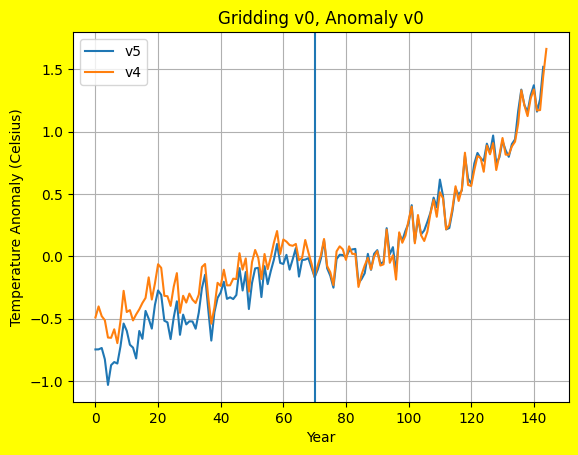

In [56]:
# Plot v4 against v5
fig, ax = plt.subplots()
fig.patch.set_facecolor('yellow')
plt.plot(weighted_timeseries_g0_a0.values, label='v5')
plt.plot(df_v4_timeseries, label='v4')
plt.axvline(x=70)
plt.grid()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (Celsius)')
plt.title('Gridding v0, Anomaly v0')

Text(0.5, 1.0, 'Gridding v0, Anomaly v1')

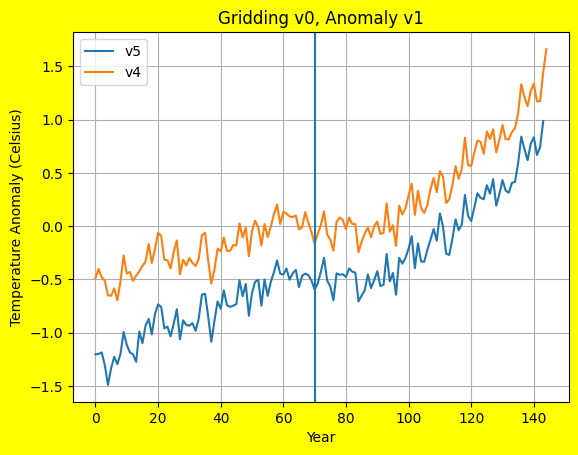

In [57]:
# Plot v4 against v5
fig, ax = plt.subplots()
fig.patch.set_facecolor('yellow')
plt.plot(weighted_timeseries_g0_a1.values, label='v5')
plt.plot(df_v4_timeseries, label='v4')
plt.axvline(x=70)
plt.grid()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (Celsius)')
plt.title('Gridding v0, Anomaly v1')

Text(0.5, 1.0, 'SHIFTED Gridding v0, Anomaly v1')

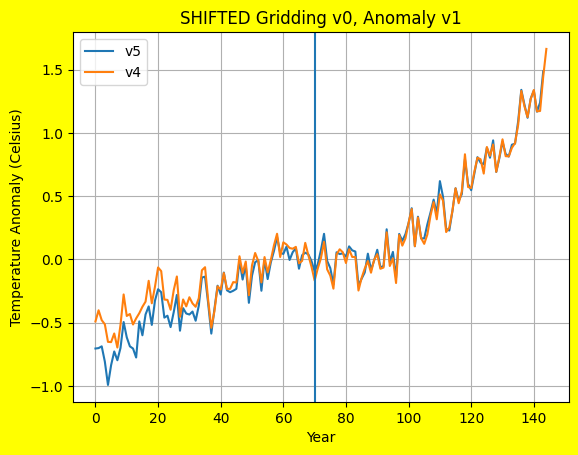

In [59]:
weighted_timeseries_g0_a1_shifted = weighted_timeseries_g0_a1 + 0.5

# Plot v4 against v5
fig, ax = plt.subplots()
fig.patch.set_facecolor('yellow')
plt.plot(weighted_timeseries_g0_a1_shifted.values, label='v5')
plt.plot(df_v4_timeseries, label='v4')
plt.axvline(x=70)
plt.grid()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (Celsius)')
plt.title('SHIFTED Gridding v0, Anomaly v1')

Text(0.5, 1.0, 'Gridding v1, Anomaly v0')

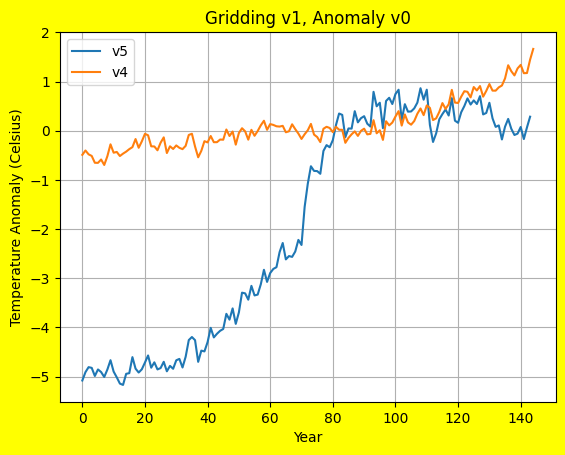

In [61]:
# Plot v4 against v5
fig, ax = plt.subplots()
fig.patch.set_facecolor('yellow')
plt.plot(weighted_timeseries_g1_a0.values, label='v5')
plt.plot(df_v4_timeseries, label='v4')
plt.grid()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (Celsius)')
plt.title('Gridding v1, Anomaly v0')